# Downstream analysis 2: Gene Set Enrichment Analysis

This tutorial is focused on running GSEA based on the loadings that the ligand-receptor pairs obtained from the tensor factorization. Tensor-cell2cell does not have functions for running GSEA directly from the tool. Here, we use the library ```gseapy```, which has its own documentation: https://gseapy.readthedocs.io/en/latest/

**IMPORTANT:** Even though we use gseapy as an external tool, we have to build a gene set for ligand-receptor pairs because the standard GSEA is intended for individual genes.

In [1]:
import cell2cell as c2c

import numpy as np
import pandas as pd

import gseapy
from statsmodels.stats.multitest import fdrcorrection
from collections import defaultdict

import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1 - Load Data

**Specify folders where the data is located, and where the outputs will be written:**

In [3]:
import os

data_folder = './'
directory = os.fsencode(data_folder)

output_folder = './results/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

**Open the loadings obtained from the tensor factorization**

In [4]:
factors = c2c.io.load_tensor_factors('./results/Loadings.xlsx')

**Load gene set used as reference to build the LR set**

In this case we use the KEGG pathways. The .gmt file was obtained from http://www.gsea-msigdb.org/gsea/downloads.jsp. If you are interested in using another gene set such as GO Terms, you can download it from the same website.

In [5]:
pathway_per_gene = defaultdict(set)
with open('KEGG.gmt', 'rb') as f:
    for i, line in enumerate(f):
        l = line.decode("utf-8").split('\t')
        l[-1] = l[-1].replace('\n', '')
        l = [pw for pw in l if ('http' not in pw)] # Remove website info
        for gene in l[1:]:
            pathway_per_gene[gene] = pathway_per_gene[gene].union(set([l[0]]))

This file contains pathways associated with each gene. For example for IL6:

In [6]:
pathway_per_gene['IL6']

{'KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION',
 'KEGG_CYTOSOLIC_DNA_SENSING_PATHWAY',
 'KEGG_GRAFT_VERSUS_HOST_DISEASE',
 'KEGG_HEMATOPOIETIC_CELL_LINEAGE',
 'KEGG_HYPERTROPHIC_CARDIOMYOPATHY_HCM',
 'KEGG_INTESTINAL_IMMUNE_NETWORK_FOR_IGA_PRODUCTION',
 'KEGG_JAK_STAT_SIGNALING_PATHWAY',
 'KEGG_NOD_LIKE_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_PATHWAYS_IN_CANCER',
 'KEGG_PRION_DISEASES',
 'KEGG_TOLL_LIKE_RECEPTOR_SIGNALING_PATHWAY'}

**Open LR pairs from CellChat**

Different databases of ligand-receptor interactions could be used. We previously created a repository that includes many available DBs (https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs). In this tutorial, we employ the ligand-receptor pairs from CellChat (https://doi.org/10.1038/s41467-021-21246-9), which includes multimeric protein complexes.

**The database must contain columns for the interactions using the same gene name nomenclature used in the .gmt file.**

In [7]:
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
lr_pairs = lr_pairs.astype(str)

In [8]:
lr_pairs.head(2)

,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,ligand_symbol,receptor_symbol,ligand_ensembl,receptor_ensembl,interaction_symbol,interaction_ensembl
0,TGFB1_TGFBR1_TGFBR2,TGFb,TGFB1,TGFbR1_R2,TGFb agonist,TGFb antagonist,nan,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB1 - (TGFBR1+TGFBR2),TGFB1,TGFBR1&TGFBR2,ENSG00000105329,ENSG00000106799&ENSG00000163513,TGFB1^TGFBR1&TGFBR2,ENSG00000105329^ENSG00000106799&ENSG00000163513
1,TGFB2_TGFBR1_TGFBR2,TGFb,TGFB2,TGFbR1_R2,TGFb agonist,TGFb antagonist,nan,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB2 - (TGFBR1+TGFBR2),TGFB2,TGFBR1&TGFBR2,ENSG00000092969,ENSG00000106799&ENSG00000163513,TGFB2^TGFBR1&TGFBR2,ENSG00000092969^ENSG00000106799&ENSG00000163513


## 2 - Generate LR set from a Gene set (KEGG LR set in this case)

Here, we label a LR interaction with a given pathway if all members of the interactions are labeled with that pathway.

In [9]:
# If the LR db include protein complexes. 
# This is the character separating members
complex_sep = '&' 

# Dictionary to save the LR interaction (key) and the annotated pathways (values).
pathway_sets = defaultdict(set)

# Iterate through the interactions in the LR DB.
for idx, row in lr_pairs.iterrows():
    lr_label = row['interaction_symbol']
    lr = lr_label.split('^')
    
    # Gene members of the ligand and the receptor in the LR pair
    if complex_sep is None:
        ligands = [lr[0]]
        receptors = [lr[1]]
    else:
        ligands = lr[0].split(complex_sep)
        receptors = lr[1].split(complex_sep)
    
    # Find pathways associated with all members of the ligand
    for i, ligand in enumerate(ligands):
        if i == 0:
            ligand_pathways = pathway_per_gene[ligand]
        else:
            ligand_pathways = ligand_pathways.intersection(pathway_per_gene[ligand])
            
    # Find pathways associated with all members of the receptor
    for i, receptor in enumerate(receptors):
        if i == 0:
            receptor_pathways = pathway_per_gene[receptor]
        else:
            receptor_pathways = receptor_pathways.intersection(pathway_per_gene[receptor])

    # Keep only pathways that are in both ligand and receptor.
    lr_pathways = ligand_pathways.intersection(receptor_pathways)
    for p in lr_pathways:
        pathway_sets[p] = pathway_sets[p].union([lr_label])

**Keep only pathways annotations that contain at least K LR pairs**

Here K=15

In [10]:
K=15

lr_set = defaultdict(set)
    
for k, v in pathway_sets.items():
    if len(v) >= K:
        lr_set[k] = v

And this results in a total of 22 pathways that were assigned to at least 15 LR pairs.

In [11]:
len(lr_set)

22

**This LR set can be exported to be used in other analyses**

In [12]:
c2c.io.export_variable_with_pickle(lr_set, output_folder + '/CellChat-LR-KEGG-set.pkl')

# It can be loaded with:
# lr_set = c2c.io.load_variable_with_pickle(output_folder + '/CellChat-LR-KEGG-set.pkl')

./results//CellChat-LR-KEGG-set.pkl  was correctly saved.


## 3 - GSEA

Here we use the ```gseapy.prerank()``` function based on the loadings of the LR pairs.

**GSEA parameters**

In [13]:
weight = 1
min_size = 15
permutations = 999
significance_threshold = 0.05

**Loadings of the LR pairs**

In [14]:
loadings = factors['Ligand-Receptor Pairs'].reset_index()

### Run the GSEA in each of the factors

In [15]:
for factor in loadings.columns[1:]:
    # Rank LR pairs of each factor by their respective loadings
    test = loadings[['index', factor]]
    test.columns = [0, 1]
    test = test.sort_values(by=1, ascending=False)
    test.reset_index(drop=True, inplace=True)

    # RUN GSEA
    gseapy.prerank(rnk=test,
                   gene_sets=lr_set,
                   min_size=min_size,
                   weighted_score_type=weight,
                   processes=6,
                   permutation_num=permutations, # reduce number to speed up testing
                   outdir=output_folder + '/GSEA/' + factor, format='png', seed=6)

**Adjust P-values across all factors (GSEA only adjusts within factor)**

First we read the files generated by gseapy within each Factor folder. Then put all those P-values together and perform a Benjamini-Hochberg correction.

In [16]:
pvals = []
terms = []
factors = []
nes = []
for factor in loadings.columns[1:]:
    p_report = pd.read_csv(output_folder + '/GSEA/' + factor + '/gseapy.prerank.gene_sets.report.csv')
    pval = p_report['pval'].values.tolist()
    pvals.extend(pval)
    terms.extend(p_report.Term.values.tolist())
    factors.extend([factor] * len(pval))
    nes.extend(p_report['nes'].values.tolist())
pval_df = pd.DataFrame(np.asarray([factors, terms, nes, pvals]).T, columns=['Factor', 'Term', 'NES', 'P-value'])
pval_df = pval_df.loc[pval_df['P-value'] != 'nan']
pval_df['P-value'] = pd.to_numeric(pval_df['P-value'])
pval_df['P-value'] = pval_df['P-value'].replace(0., 1./(permutations+1))
pval_df['NES'] = pd.to_numeric(pval_df['NES'])

BH correction:

In [17]:
pval_df['Adj. P-value'] = fdrcorrection(pval_df['P-value'].values,
                                        alpha=significance_threshold)[1]

**Enriched LR pairs**

In [18]:
pval_df.loc[(pval_df['Adj. P-value'] < significance_threshold) & (pval_df['NES'] > 0.)]

,Factor,Term,NES,P-value,Adj. P-value
1,Factor 1,KEGG_ERBB_SIGNALING_PATHWAY,1.454242,0.001000,0.008709
2,Factor 1,KEGG_CELL_ADHESION_MOLECULES_CAMS,1.398443,0.001000,0.008709
3,Factor 1,KEGG_AXON_GUIDANCE,1.241130,0.006006,0.029029
17,Factor 2,KEGG_AXON_GUIDANCE,1.563928,0.001000,0.008709
18,Factor 2,KEGG_CELL_ADHESION_MOLECULES_CAMS,1.309822,0.005005,0.029029
31,Factor 3,KEGG_ERBB_SIGNALING_PATHWAY,1.486924,0.003003,0.018662
32,Factor 3,KEGG_AXON_GUIDANCE,1.388006,0.001001,0.008709
34,Factor 3,KEGG_ECM_RECEPTOR_INTERACTION,1.327261,0.001000,0.008709
35,Factor 3,KEGG_SMALL_CELL_LUNG_CANCER,1.335054,0.008008,0.033176
36,Factor 3,KEGG_FOCAL_ADHESION,1.279068,0.001001,0.008709


**Depleted LR pairs**

In [19]:
pval_df.loc[(pval_df['Adj. P-value'] < significance_threshold) & (pval_df['NES'] < 0.)]

,Factor,Term,NES,P-value,Adj. P-value
0,Factor 1,KEGG_NOTCH_SIGNALING_PATHWAY,-1.380117,0.001,0.008709
15,Factor 2,KEGG_NOTCH_SIGNALING_PATHWAY,-2.423423,0.001,0.008709


**Exported Normalized Enrichment Scores and their adjusted P-values across factors**

In [20]:
pval_df.to_excel(output_folder + '/GSEA-Adj-Pvals.xlsx')

### Visualization

DataFrame needed for the pval_plot included in cell2cell

In [21]:
pval_pivot = pval_df.pivot(index="Term", columns="Factor", values="Adj. P-value").fillna(1.)
scores = pval_df.pivot(index="Term", columns="Factor", values="NES").fillna(0)

Dot Plot

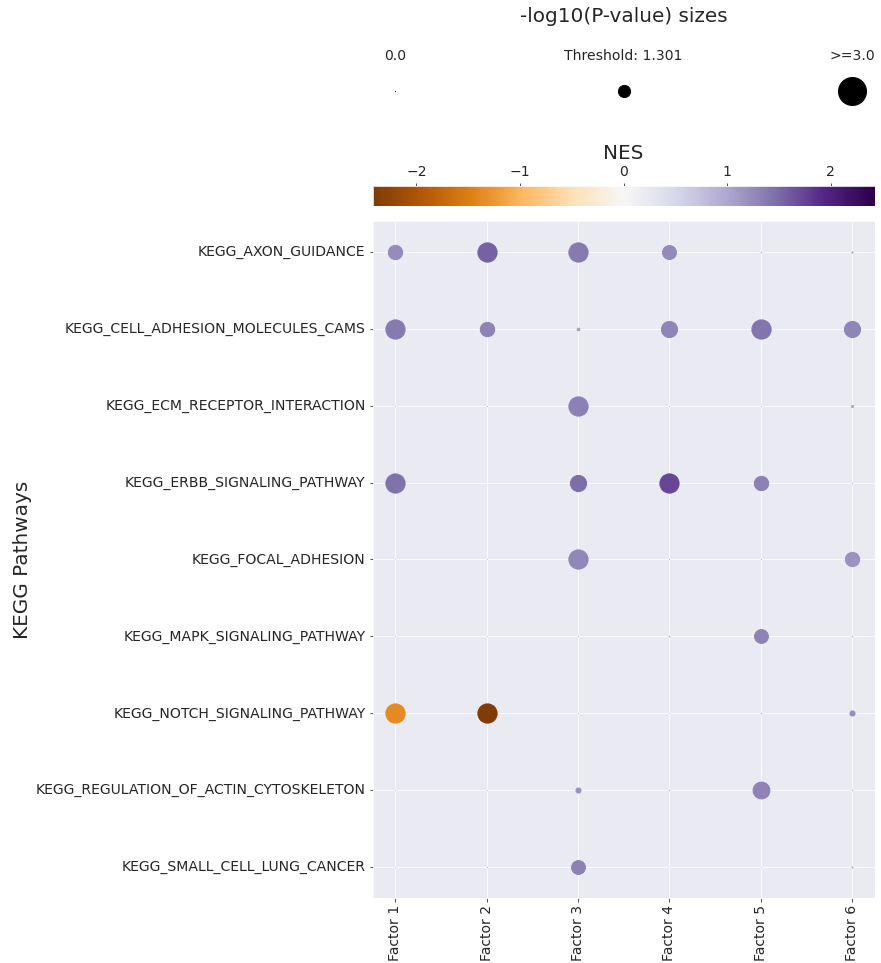

In [22]:
with sns.axes_style("darkgrid"):
    dotplot = c2c.plotting.pval_plot.generate_dot_plot(pval_df=pval_pivot,
                                                       score_df=scores,
                                                       significance=significance_threshold,
                                                       xlabel='',
                                                       ylabel='KEGG Pathways',
                                                       cbar_title='NES',
                                                       cmap='PuOr',
                                                       figsize=(9,16),
                                                       label_size=20,
                                                       title_size=20,
                                                       tick_size=14,
                                                       filename=output_folder + '/GSEA-Dotplot.svg'
                                                      )

This dot plot indicates the pathways or LR sets enriched/depleted (depending on the color) in each of the factors. The size of the circles indicates whether they are significant. The threshold size is for the significance threshold (usually P < 0.05).